## **STEP 1: Mount Google Drive and Load Data bold text**

In [1]:
# --- STEP 1: Mount Google Drive and Load Data ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OrdinalEncoder
from google.colab import drive
import shap # For SHAP plots, though not directly run in the final metrics output

drive.mount('/content/drive')

# Load datasets
df_quotes = pd.read_csv('/content/drive/MyDrive/Coverwallet/quotes_train.csv')
df_account = pd.read_csv('/content/drive/MyDrive/Coverwallet/accounts_train.csv')
df_quotes_test = pd.read_csv('/content/drive/MyDrive/Coverwallet/quotes_test.csv')
df_account_test = pd.read_csv('/content/drive/MyDrive/Coverwallet/accounts_test.csv')

print("STEP 1: Data loaded successfully.")
print(f"df_quotes shape: {df_quotes.shape}")
print(f"df_account shape: {df_account.shape}")
print(f"df_quotes_test shape: {df_quotes_test.shape}")
print(f"df_account_test shape: {df_account_test.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
STEP 1: Data loaded successfully.
df_quotes shape: (11724, 5)
df_account shape: (5709, 9)
df_quotes_test shape: (5005, 4)
df_account_test shape: (2448, 9)


## **STEP 2: Clean Training Data**

In [2]:
# --- STEP 2: Clean Training Data ---
df_quotes.drop_duplicates(inplace=True)

# Compute account value where convert == 1
df_value = df_quotes[df_quotes['convert'] == 1].groupby('account_uuid')['premium'].sum().reset_index()
df_value.rename(columns={'premium': 'account_value'}, inplace=True)

# Aggregate quote-level features
quote_agg = df_quotes.groupby('account_uuid').agg({
    'product': lambda x: list(set(x)),
    'premium': 'mean'
}).reset_index()
quote_agg.rename(columns={'premium': 'avg_premium'}, inplace=True)

# Merge features and targets
df_model = df_account.merge(quote_agg, on='account_uuid', how='left')
df_model = df_model.merge(df_value, on='account_uuid', how='left')

# Ensure valid product lists (handle cases where 'product' might not be a list)
df_model['product'] = df_model['product'].apply(lambda x: x if isinstance(x, list) else [])

# Map full state names to abbreviations
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'New York': 'NY', 'Oregon': 'OR', 'Florida': 'FL',
    'Washington DC': 'DC', 'Pennsylvania': 'PA', 'PA - Pennsylvania': 'PA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE',
    'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
df_model['state'] = df_model['state'].map(us_state_abbrev).fillna(df_model['state'])

print("STEP 2: Training data cleaned and merged.")
print(f"df_model shape after cleaning: {df_model.shape}")
df_model.head()

STEP 2: Training data cleaned and merged.
df_model shape after cleaning: (5709, 12)


,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees,product,avg_premium,account_value
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0,[General_Liability],1542.50,1908.00
1,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Instal...,2012.0,60000.0,40000.0,Limited Liability Company,1.0,[Business_Owners_Policy_BOP],970.00,970.00
2,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0,[General_Liability],816.00,816.00
3,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0,"[CW_Professional_Liability, CW_Inland_Marine]",1020.00,2040.00
4,2b2ceb23-20eb3-9a3c-87034-2eccac7276,AZ,Retail Trade,Tobacco Stores,2014.0,200000.0,0.0,Limited Liability Company,0.0,[Business_Owners_Policy_BOP],887.52,887.52


## **STEP 3: Preprocess Train Data**

In [3]:
# --- STEP 3: Preprocess Train Data ---
numeric_cols = ['year_established', 'annual_revenue', 'total_payroll', 'num_employees', 'avg_premium', 'account_value']

# Calculate Product Premium Rank
temp_product_df = df_quotes[['product', 'premium']].copy()
product_premium_sum = temp_product_df.groupby('product')['premium'].sum().sort_values(ascending=False).reset_index()
product_premium_sum['product_rank'] = product_premium_sum['premium'].rank(method='dense', ascending=False)
product_rank_map = product_premium_sum.set_index('product')['product_rank'].to_dict()
median_product_rank = product_premium_sum['product_rank'].median()

# Calculate Subindustry Premium Rank
sub_industry_premium_sum = df_model.groupby('subindustry')['avg_premium'].sum().sort_values(ascending=False).reset_index()
sub_industry_premium_sum['subindustry_rank'] = sub_industry_premium_sum['avg_premium'].rank(method='dense', ascending=False)
sub_industry_rank_map = sub_industry_premium_sum.set_index('subindustry')['subindustry_rank'].to_dict()
median_sub_industry_rank = sub_industry_premium_sum['subindustry_rank'].median()

# Apply Product Premium Rank to df_model
df_model['product_ranks_list'] = df_model['product'].apply(
    lambda products: [product_rank_map.get(p, median_product_rank) for p in products if p != 'Unknown']
)
df_model['avg_product_rank'] = df_model['product_ranks_list'].apply(
    lambda x: np.mean(x) if x else median_product_rank
)
df_model.drop(columns=['product_ranks_list'], inplace=True)

# Apply Subindustry Premium Rank to df_model
df_model['subindustry_rank'] = df_model['subindustry'].map(sub_industry_rank_map)
df_model['subindustry_rank'] = df_model['subindustry_rank'].fillna(median_sub_industry_rank)

# Total Account Value for Each State
state_total_value = df_model.groupby('state')['account_value'].sum().reset_index()
state_total_value.rename(columns={'account_value': 'total_state_account_value'}, inplace=True)
state_total_value_map = state_total_value.set_index('state')['total_state_account_value'].to_dict()

median_total_state_account_value = state_total_value['total_state_account_value'].median() if not state_total_value.empty else 0
df_model['total_state_account_value'] = df_model['state'].map(state_total_value_map).fillna(median_total_state_account_value)

# Update numeric_cols list
if 'total_state_account_value' not in numeric_cols:
    numeric_cols.append('total_state_account_value')
if 'subindustry_rank' not in numeric_cols:
    numeric_cols.append('subindustry_rank')
if 'avg_product_rank' not in numeric_cols:
    numeric_cols.append('avg_product_rank')

# Fill missing numeric with median (using medians from the training data)
for col in numeric_cols:
    df_model[col] = df_model[col].fillna(df_model[col].median())

# Fill missing categoricals with 'Unknown'
for col in ['state', 'industry', 'business_structure']:
    df_model[col] = df_model[col].fillna('Unknown')

# One-hot encode exploded product types (for product flags)
df_exploded = df_model[['account_uuid', 'product']].explode('product')
product_dummies = pd.get_dummies(df_exploded['product'])
product_dummies['account_uuid'] = df_exploded['account_uuid']
product_flags = product_dummies.groupby('account_uuid').max().reset_index()
product_flags = product_flags.astype({col: 'int' for col in product_flags.columns if col != 'account_uuid'})

# Merge flags and drop product list
df_model = df_model.drop(columns=['product'])
df_model = df_model.merge(product_flags, on='account_uuid', how='left')

# Encode categoricals using OrdinalEncoder (fit on training data)
cols_to_encode_ordinal = ['state', 'industry', 'business_structure']
ordinal_encoders = {}
for col in cols_to_encode_ordinal:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_model[col] = oe.fit_transform(df_model[[col]])
    ordinal_encoders[col] = oe

# --- log1p transformation to reduce skew for features ---
df_model[['avg_premium_log', 'annual_revenue_log']] = df_model[['avg_premium', 'annual_revenue']].apply(np.log1p)
df_model = df_model.drop(columns=['avg_premium', 'annual_revenue'])

print("STEP 3: Training data preprocessed.")
print(f"df_model shape after preprocessing: {df_model.shape}")
df_model.head()

final_feature_columns_for_saving = [col for col in df_model.columns if col not in [
    'account_uuid', 'account_value', 'subindustry'
]]

# Store all necessary preprocessing objects in a single dictionary
preprocessing_objects = {
    'ordinal_encoders': ordinal_encoders,
    'product_rank_map': product_rank_map,
    'median_product_rank': median_product_rank,
    'sub_industry_rank_map': sub_industry_rank_map,
    'median_sub_industry_rank': median_sub_industry_rank,
    'state_total_value_map': state_total_value_map,
    'median_total_state_account_value': median_total_state_account_value,
    'X_train_columns': final_feature_columns_for_saving # Save the order of columns for consistent prediction
}

STEP 3: Training data preprocessed.
df_model shape after preprocessing: (5709, 48)


## **STEP 4: Model Training**

In [4]:
# --- STEP 4: Model Training ---

# Feature Selection
feature_columns = [col for col in df_model.columns if col not in [
    'account_uuid', 'account_value', 'subindustry', 'product'
]]
X = df_model[feature_columns]

# --- apply log1p to the target variable y ---
y = np.log1p(df_model['account_value'])

uuids = df_model['account_uuid']

# Train/Test Split (with UUIDs)
X_train, X_val, y_train, y_val, uuid_train, uuid_val = train_test_split(
    X, y, uuids, test_size=0.2, random_state=42
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

# --- Hyperparameter Tuning with GridSearchCV ---
rmse_scorer_log = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [5, 7],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

xgb_base_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_base_model,
    param_grid=param_grid,
    scoring=rmse_scorer_log,
    cv=3,
    n_jobs=-1,
    verbose=0
)

print("\nStarting GridSearchCV for optimal XGBoost parameters (on log-transformed target)...")
grid_search.fit(X_train, y_train)

print("\nGridSearchCV finished.")

best_params = grid_search.best_params_
best_cv_rmse_log = -grid_search.best_score_

print(f"\nBest Cross-Validation RMSE (on LOG scale) found: {best_cv_rmse_log:.4f}")
print(f"Best parameters from GridSearchCV: {best_params}")

model = grid_search.best_estimator_ # Select the best model

# --- Make Predictions on Validation Set (Using the Best Model) ---
y_pred_val_log = model.predict(X_val)

# --- INVERSE TRANSFORM for Evaluation on ORIGINAL Scale ---
y_pred_val_original_scale = np.expm1(y_pred_val_log)
y_val_original_scale = np.expm1(y_val) # y_val was log-transformed in the split

# --- Ensure no negative predictions on original scale (should be rare post expm1) ---
y_pred_val_original_scale[y_pred_val_original_scale < 0] = 0

# --- Evaluate Performance on ORIGINAL Scale ---
rmse_final = np.sqrt(mean_squared_error(y_val_original_scale, y_pred_val_original_scale))
print(f"\nRoot Mean Squared Error (RMSE) on the ORIGINAL scale (validation set): {rmse_final:.4f}")

# Calculate MAPE on original scale, handle division by zero
mape_final = np.nanmean(np.abs((y_val_original_scale - y_pred_val_original_scale) / y_val_original_scale.replace(0, np.nan))) * 100
print(f"Mean Absolute Percentage Error (MAPE) on the ORIGINAL scale: {mape_final:.2f}%")

# --- Preview Actual vs Predicted with UUIDs (on ORIGINAL Scale) ---
comparison_df = pd.DataFrame({
    'account_uuid': uuid_val.reset_index(drop=True),
    'Actual': y_val_original_scale.reset_index(drop=True),
    'Predicted': pd.Series(y_pred_val_original_scale)
})

print("\nSample of Actual vs Predicted Account Values (Validation Set - ORIGINAL SCALE):")
# Sort by Actual value to see how it handles large vs small values
print(comparison_df.sort_values(by='Actual', ascending=False).head(15))
print(comparison_df.sort_values(by='Actual', ascending=True).head(15))


Shape of X_train: (4567, 45)
Shape of X_val: (1142, 45)
Shape of y_train: (4567,)
Shape of y_val: (1142,)

Starting GridSearchCV for optimal XGBoost parameters (on log-transformed target)...

GridSearchCV finished.

Best Cross-Validation RMSE (on LOG scale) found: 0.3633
Best parameters from GridSearchCV: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

Root Mean Squared Error (RMSE) on the ORIGINAL scale (validation set): 1549.4859
Mean Absolute Percentage Error (MAPE) on the ORIGINAL scale: 26.06%

Sample of Actual vs Predicted Account Values (Validation Set - ORIGINAL SCALE):
                              account_uuid    Actual     Predicted
363   87047ec6-4ef1c-73fe-a7c25-53b93d54c2  52382.00  28264.878906
963   e1613a34-eca2-4589-940d-e49fe339a25c  46333.00  36371.066406
553   e11b13c3-53ebb-ba34-17f72-ce7ad2445c  36115.54  12089.728516
1038  b8e47b5f-9cd4d-7f47-72f7e-657d90e809  35409.28  21247.583984
351   69fdc79b-98ed-424

## **STEP 5: SHAP Explainability**


STEP 5: Generating SHAP Explainability plots (this might take a moment)...


 99%|===================| 4505/4567 [00:48<00:00]       

SHAP summary plot generated.


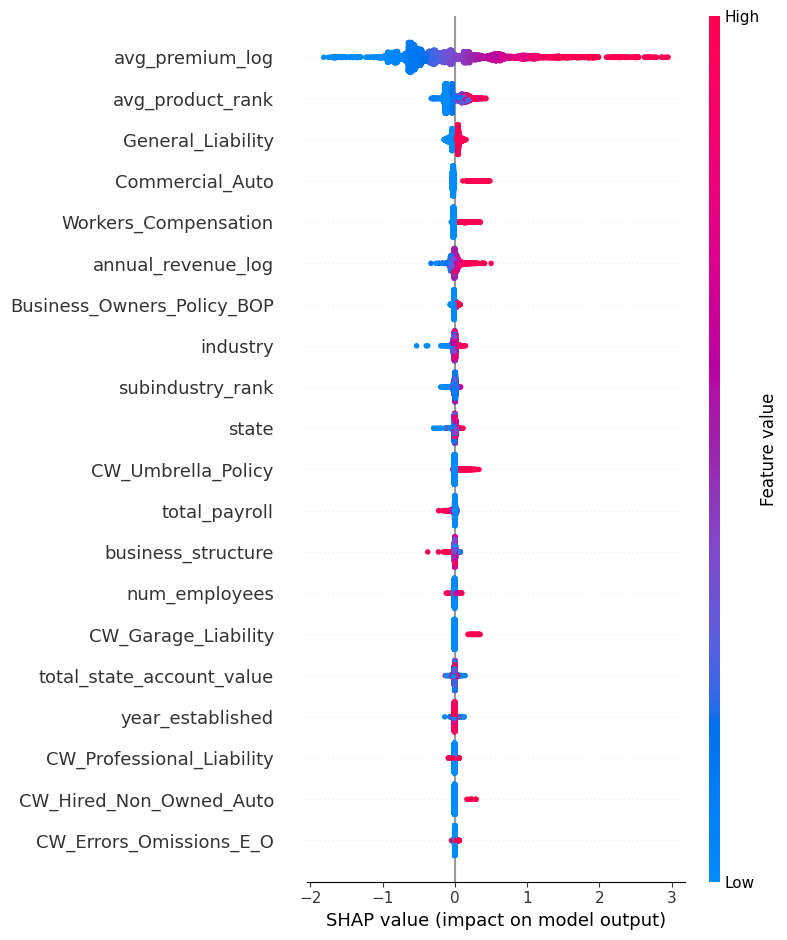

In [5]:
# --- STEP 5: SHAP Explainability ---
print("\nSTEP 5: Generating SHAP Explainability plots (this might take a moment)...")
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, show=False)
print("SHAP summary plot generated.")

## **STEP 6: Preprocess Test Data**

In [6]:
# --- STEP 6: Preprocess Test Data ---
df_quotes_test.drop_duplicates(inplace=True)
quote_test_agg = df_quotes_test.groupby('account_uuid').agg({
    'product': lambda x: list(set(x)),
    'premium': 'mean'
}).reset_index()
quote_test_agg.rename(columns={'premium': 'avg_premium'}, inplace=True)

df_test = df_account_test.merge(quote_test_agg, on='account_uuid', how='left')
df_test['product'] = df_test['product'].apply(lambda x: x if isinstance(x, list) else [])

# Apply log1p to avg_premium and annual_revenue in test data
df_test[['avg_premium_log', 'annual_revenue_log']] = df_test[['avg_premium', 'annual_revenue']].apply(np.log1p)
df_test = df_test.drop(columns=['avg_premium', 'annual_revenue'])

# Apply Product Premium Rank to df_test using map from training data
df_test['product_ranks_list'] = df_test['product'].apply(
    lambda products: [
        product_rank_map.get(p, median_product_rank)
        for p in products if p != 'Unknown'
    ]
)
df_test['avg_product_rank'] = df_test['product_ranks_list'].apply(
    lambda x: np.mean(x) if x else median_product_rank
)
df_test.drop(columns=['product_ranks_list'], inplace=True)

# Apply Subindustry Premium Rank to df_test using map from training data
df_test['subindustry_rank'] = df_test['subindustry'].map(sub_industry_rank_map)
df_test['subindustry_rank'] = df_test['subindustry_rank'].fillna(median_sub_industry_rank)

# Ensure state abbreviations are applied before mapping total_state_account_value
df_test['state'] = df_test['state'].map(us_state_abbrev).fillna(df_test['state'])
# Total Account Value for Each State
df_test['total_state_account_value'] = df_test['state'].map(state_total_value_map).fillna(median_total_state_account_value)


# --- CORRECTED PRODUCT FLAGS GENERATION FOR TEST DATA ---
df_exploded_test = df_test[['account_uuid', 'product']].explode('product')
product_dummies_test = pd.get_dummies(df_exploded_test['product'])

# Concatenate account_uuid with the one-hot encoded product flags BEFORE grouping
product_flags_temp = pd.concat([df_exploded_test['account_uuid'], product_dummies_test], axis=1)

# Group by account_uuid and get the max for each product (1 if present, 0 otherwise)
product_flags_test = product_flags_temp.groupby('account_uuid').max()

# Get the list of product columns that were in the training set (from X_train.columns)
train_product_cols_set = {col for col in X_train.columns if col.startswith('CW_') or col.startswith('Commercial_') or col == 'Package' or col == 'General_Liability' or col == 'Workers_Compensation' or col == 'Business_Owners_Policy_BOP'}

# Reindex product flags to match training columns, filling missing with 0
product_flags_test = product_flags_test.reindex(columns=list(train_product_cols_set), fill_value=0)

# Reset index to make 'account_uuid' a regular column again
product_flags_test = product_flags_test.reset_index()

# Ensure the columns are integer type
product_flags_test = product_flags_test.astype({col: 'int' for col in product_flags_test.columns if col != 'account_uuid'})

# Merge product flags into df_test and drop the original product list column
df_test = df_test.drop(columns=['product'])
df_test = df_test.merge(product_flags_test, on='account_uuid', how='left')


# Handle missing values in numeric columns in test set
numeric_cols_to_fill = [
    'year_established', 'total_payroll', 'num_employees',
    'avg_premium_log', 'annual_revenue_log',
    'avg_product_rank', 'subindustry_rank', 'total_state_account_value'
]

for col in numeric_cols_to_fill:
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna(df_model[col].median())

# Fill missing categoricals with 'Unknown'
categorical_cols_to_fill_and_encode = ['state', 'industry', 'business_structure']
for col in categorical_cols_to_fill_and_encode:
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna('Unknown')

# Apply encoders (using the fitted encoders from training data)
cols_to_encode_ordinal = ['state', 'industry', 'business_structure']
for col in cols_to_encode_ordinal:
    if col in df_test.columns:
        # Crucial: Use the stored ordinal_encoders, not fit_transform again
        df_test[col] = ordinal_encoders[col].transform(df_test[[col]])

print("\nSTEP 6: Test data preprocessed.")
print(f"df_test shape after preprocessing: {df_test.shape}")
df_test.head()


STEP 6: Test data preprocessed.
df_test shape after preprocessing: (2448, 41)


,account_uuid,state,industry,subindustry,year_established,total_payroll,business_structure,num_employees,avg_premium_log,annual_revenue_log,...,CW_Hired_Non_Owned_Auto,CW_Umbrella_Policy,CW_Directors_Officers_D_O,CW_Professional_Liability,Commercial_Property,CW_Employment_Practices_Liability_Insurance_EPLI,CW_Garage_Liability,Workers_Compensation,CW_GL_and_E_O,CW_Fidelity_Bond
0,7c7089b9-30cc6-c5fc-9f5c8-1e4ce6a8c3,9.0,18.0,Software Publishers,2014.0,1000000.0,0.0,11.0,7.137350,13.997833,...,0,0,0,0,0,0,0,0,0,0
1,bf68dd36-7dc94-0f5d-ebad4-19c0cdcdc7,43.0,0.0,Carpet and Upholstery Cleaning Services,2017.0,1.0,1.0,0.0,7.108244,11.225257,...,0,0,0,0,0,0,0,0,0,0
2,fc97744d-9e9a-47a9-b923-1e2c3016c896,4.0,8.0,Diagnostic Imaging Centers,2018.0,70000.0,2.0,3.0,6.980541,13.122365,...,0,0,0,0,0,0,0,1,0,0
3,0484a0e0-3c35e-0d2a-14c01-0220295202,5.0,3.0,Administrative Management and General Manageme...,2017.0,0.0,1.0,0.0,5.789960,11.156265,...,0,0,0,0,0,0,0,1,0,0
4,673e8fb9-23833-3654-c6082-67470cfedb,1.0,20.0,NaN,2017.0,0.0,6.0,0.0,8.457231,11.957618,...,0,0,0,0,0,0,0,0,0,0


## **STEP 7: Predict and Export**

In [7]:
# --- STEP 7: Predict and Export ---

X_test = df_test.drop(columns=[
    'account_uuid', 'subindustry'
], errors='ignore') # 'product' and 'account_value' are already handled or not present

# Align columns with X_train (add missing columns as 0, remove extra ones)
missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Make predictions (these will be on the log scale from the model)
predictions_log = model.predict(X_test)

# --- INVERSE TRANSFORM FINAL PREDICTIONS FOR SUBMISSION ---
df_test['account_value'] = np.expm1(predictions_log)

# Clip any negative predictions (can sometimes occur after expm1 if log prediction was very low)
df_test['account_value'] = df_test['account_value'].clip(lower=0)

# Create submission file
submission = df_test[['account_uuid', 'account_value']]
submission.to_csv('submission.csv', index=False)

print("\nSTEP 7: Predictions made and submission.csv generated.")
print("Sample of top 10 predicted account values for submission:")
print(submission.sort_values('account_value', ascending=False).head(10))



STEP 7: Predictions made and submission.csv generated.
Sample of top 10 predicted account values for submission:
                              account_uuid  account_value
2447  820a6a83-cbaf-4df3-86d0-e0dc2f7faf22   32386.337891
1871  f67972e0-d3b37-751e-c424f-75b11e0b7f   31351.500000
1493  7f250467-5add3-ed1a-e7cc8-d697c67717   29466.220703
1099  aaa1beb5-1bca8-efb7-90300-579a138f93   29159.101562
1319  a2e18499-d3904-6a8d-e8c9f-08f2a51b86   27058.576172
1911  e8ae907d-a5e8d-e9ab-425a7-5da152a8da   25969.578125
249   658a6efd-41ddc-db95-d7829-fd67175ef0   23654.142578
1672  5b0eba5b-9dc0a-5e8d-bb976-44d4601309   21154.410156
1815  6fe5661e-dc91f-4754-c3d1d-5d0e28863d   20604.068359
1056  df535f5a-1336d-70d7-be0dd-b1efa42b32   20114.261719


In [8]:
# Run this cell after you have executed all previous STEPs and 'model'
# and 'preprocessing_objects' are defined.

import joblib
import os

# Define filenames for your saved objects
model_filename = 'xgboost_account_value_model.pkl'
preprocessing_filename = 'preprocessing_objects.pkl'
# Optionally, if you want to explicitly save the X_train column names for robust API usage
# X_train_columns_filename = 'X_train_columns.pkl' # You'll need to define X_train_columns = X_train.columns in Step 4

# Save the trained model
joblib.dump(model, model_filename)
print(f"Model saved to: {model_filename}")

# Save the preprocessing objects dictionary
joblib.dump(preprocessing_objects, preprocessing_filename)
print(f"Preprocessing objects saved to: {preprocessing_filename}")

# If you decided to save X_train.columns:
# joblib.dump(X_train.columns.tolist(), X_train_columns_filename)
# print(f"X_train column names saved to: {X_train_columns_filename}")

# Verify the files are created in the Colab environment
print("\nFiles in current directory:")
!ls -lh

Model saved to: xgboost_account_value_model.pkl
Preprocessing objects saved to: preprocessing_objects.pkl

Files in current directory:
total 876K
drwx------ 5 root root 4.0K Jun 25 17:13 drive
-rw-r--r-- 1 root root  28K Jun 25 17:59 preprocessing_objects.pkl
drwxr-xr-x 1 root root 4.0K Jun 24 13:38 sample_data
-rw-r--r-- 1 root root 112K Jun 25 17:59 submission.csv
-rw-r--r-- 1 root root 728K Jun 25 17:59 xgboost_account_value_model.pkl
